In [17]:
import itertools
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import pandas as pd

from scipy.stats import binom, norm
from math import comb

In [18]:
K_true = 3
M_true = np.array([3, 4, 2])

P_true = np.array([0.25, 0.35, 0.4])
Q_true = np.array([0.1, 0.3, 0.9])


X_param_true = np.array([[-5, 1.5],
                         [2, 1.6],
                         [7, 2.2]])


Y_param_true = np.array([[[-1, 0.5], [5, 1.5], [9, 0.5], [12, 0.8]],
                         [[-2, 0.5], [8, 0.9], [12, 0.8], [16, 0.8]],
                         [[-2, 0.5], [7, 0.9], [13, 0.8], [17, 0.8]]])

In [19]:
def generate_data():
    # Choose idx of mixture on X
    i = np.random.choice(K_true, p=P_true)

    # Choose amount of latent variables in this mixture
    eta = 1 + np.random.binomial(n=M_true[i]-1, p=Q_true[i])

    # Choose mixture latent variable
    l = np.random.choice(a=eta)

    x = np.random.normal(X_param_true[i, 0], np.sqrt(X_param_true[i, 1]))
    y = np.random.normal(Y_param_true[i, l][0], np.sqrt(Y_param_true[i, l][1]))

    return x, y, np.sum(M_true[:i]) + l

In [20]:
def generate_dataset(n_samples, random_state=42):
    np.random.seed(random_state)

    data = []
    labels = []


    for _ in range(n_samples):
        x, y, label = generate_data()
        data.append(np.array([x, y]))
        labels.append(label)

    return np.array(data), np.array(labels)

In [21]:
data, labels = generate_dataset(1500)

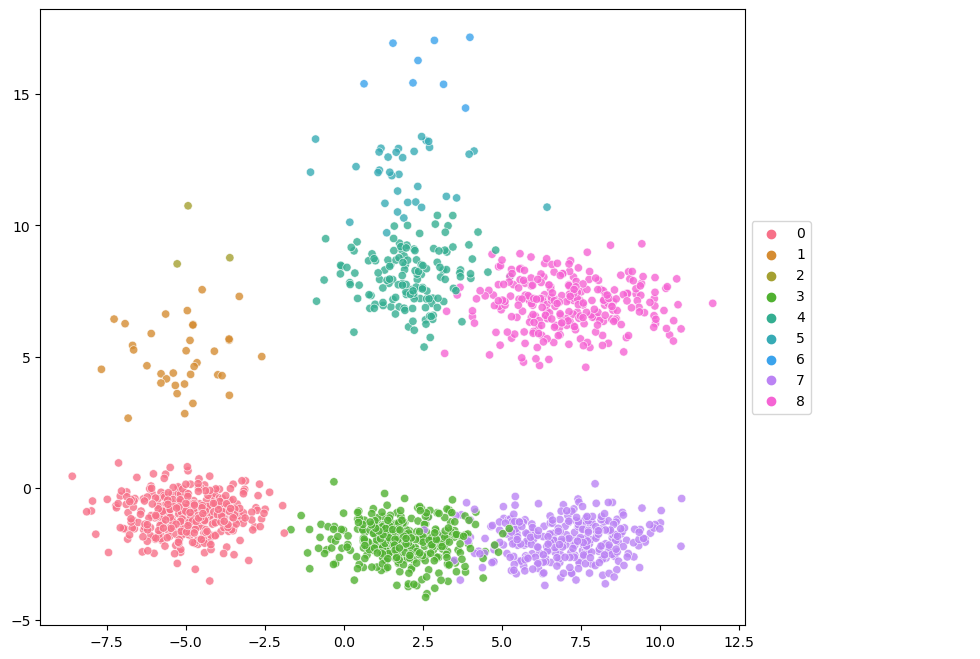

In [22]:
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1])
# Use Seaborn's "husl" palette for n colors
custom_palette = sns.color_palette("husl", len(np.unique(labels)))  

# Create the scatterplot on the left side
ax1 = plt.subplot(grid[0, 0])
scatter = sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax1, palette=custom_palette)

# Create a separate axis for the legend on the right side
ax2 = plt.subplot(grid[0, 1])
ax2.axis('off')  # Hide the axis for the legend
legend = ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [23]:
class EMModel:
    def __init__(self):
        self.denominator_pi = None

        self.K = None
        # M - array
        self.M = None
        self.P = None
        # Q - array
        self.Q = None
        self.X_param = None
        self.Y_param = None

        self.current_likelihood_ = None
    


    def fit(self, data, M, P, Q, X_param, Y_param, epochs):
        n = data.shape[0]
        self.K = P.shape[0]
        self.M = np.copy(M)
        self.P = np.copy(P)
        self.Q = np.copy(Q)
        self.X_param = np.copy(X_param)
        self.Y_param = np.copy(Y_param)

        # Estimate prior variance
        self.prior_variance = 1

        # Estimate prior means
        self.prior_means = np.zeros(shape=(self.K, np.max(self.M)))

        # Estimate prior kappas
        self.prior_kappas = np.zeros(shape=(self.K, np.max(self.M)))
        
        # for i in range(self.K):
        #     self.prior_means[i, :self.M[i]] = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), self.M[i])
            
        #     std = (self.prior_means[i, 1] - self.prior_means[i, 0]) * 0.5
        #     for l in range(0, self.M[i]):
        #         self.prior_kappas[i, l] = 2 * self.prior_variance / std
        
        ##########################

        # Estimate nu
        self.nu = 3


        print("Prior means->", self.prior_means)
        print("Prior kappas->", self.prior_kappas)
        
        resp_shape = (n, self.K, np.max(self.M), np.max(self.M))
        responsibilities = np.zeros(resp_shape, dtype=np.longdouble)

        start_time = time.time()

        self.current_likelihood_ = np.zeros(epochs)
        for epoch in range(epochs):
            print("Epoch:", epoch)
            # E-Step
            # Calculate responsibilities 

            for t, (x, y) in enumerate(data):
                for i in range(0, self.K):
                    for j in range(1, self.M[i] + 1):
                        for l in range(0, j):
                            responsibilities[t, i, j - 1, l] = self.calculate_responsb_(x, y, i, j, l)

                
                s_t = np.sum(responsibilities[t, :, :, :])
                responsibilities[t, :, :, :] /= s_t
                self.current_likelihood_[epoch] += np.log(s_t)
        

            print("E-Step done")
            end_time = time.time()
            print(f"Time elapsed: {end_time - start_time} seconds")
        

            # M-Step
            # Update parameters

            # Update P
            for i in range(self.K):
                self.P[i] = np.sum(responsibilities[:, i, :, :]) / n

            # Update Q
            for i in range(self.K):
                res = 0
                for j in range(0, self.M[i]):
                    res += j * np.sum(responsibilities[:, i, j, :])

                self.Q[i] = res / ((self.M[i] - 1) * np.sum(responsibilities[:, i, :, :]))

            
            # Update mean for X
            for i in range(self.K):
                res = 0
                for t in range(n):
                    res += np.sum(responsibilities[t, i, :, :]) * data[t, 0]
                self.X_param[i, 0] = res / np.sum(responsibilities[:, i, :, :])
            
            # Update variance for X
            for i in range(self.K):
                res = 0
                for t in range(n):
                    res += np.sum(responsibilities[t, i, :, :]) * (data[t, 0] - self.X_param[i, 0])**2
                self.X_param[i, 1] = res / np.sum(responsibilities[:, i, :, :])
            
            
            # Update mean for Y
            for i in range(self.K):
                for l in range(self.M[i]):

                    res = 0
                    for j in range(self.M[i]):
                        for t in range(n):
                            res += responsibilities[t, i, j, l] * data[t, 1]

                    self.Y_param[i, l, 0] = (self.prior_kappas[i, l] * self.prior_means[i, l]  + res) /\
                                            (self.prior_kappas[i, l] + np.sum(responsibilities[:, i, :, l]))

            
            # Update variance for Y
            for i in range(self.K):
                for l in range(self.M[i]):

                    res = 0
                    for j in range(self.M[i]):
                        for t in range(n):
                            res += responsibilities[t, i, j, l] * (data[t, 1] - self.Y_param[i, l, 0])**2

                    self.Y_param[i, l, 1] = (res + self.prior_variance + self.prior_kappas[i, l]*(self.prior_means[i, l] - self.Y_param[i, l, 0])**2) /\
                                            (np.sum(responsibilities[:, i, :, l]) + self.nu + 3)
            
            print("M-step done")

            print("Current log likelihood:", self.current_likelihood_[epoch])
            print("P:\n", self.P)
            print("Q:\n", self.Q)
            print("X_param\n", self.X_param)
            print("Y_param\n", self.Y_param)

    def calculate_pi_(self, i, j, l):
        return self.P[i] * binom.pmf(k=j-1, n=self.M[i]-1, p=self.Q[i]) / j


    def calculate_responsb_(self, x, y, i, j, l):
        res = self.calculate_pi_(i, j, l) * \
            norm.pdf(x, loc=self.X_param[i, 0], scale=np.sqrt(self.X_param[i, 1])) * \
            norm.pdf(y, loc=self.Y_param[i, l][0], scale=np.sqrt(self.Y_param[i,l][1]))
        
        return res

In [24]:
from sklearn.cluster import KMeans

In [25]:
def generate_est_parameters(data, random_state):
    np.random.seed(random_state)

    # Estimate P
    P_est = np.full(K_true, 1/K_true)
    noise = np.random.dirichlet(np.ones(K_true))
    P_est += noise * 0.05
    P_est /= np.sum(P_est)

    # Estimate Q
    Q_est = np.random.uniform(size=K_true, low=0.1, high=0.9)
    
    # Estimate X, Y
    X_param_est = np.zeros((K_true, 2))
    Y_param_est = np.zeros((K_true, np.max(M_true), 2))

    min_x = np.min(data[:, 0])
    max_x = np.max(data[:, 0])
    intervals = np.linspace(min_x, max_x, K_true + 1)

    for i in range(0, K_true):
        X_param_est[i][0] = np.random.uniform(intervals[i], intervals[i+1])
        X_param_est[i][1] = np.random.uniform(0, (intervals[i+1] - intervals[i])/6)
    
    min_y = np.min(data[:, 1])
    max_y = np.max(data[:, 1])

    intervals = np.linspace(min_y, max_y, np.max(M_true) + 1)


    for i in range(0, K_true):
        for j in range(0, M_true[i]):
            Y_param_est[i, j, 0] = np.random.uniform(intervals[j], intervals[j + 1])
            Y_param_est[i, j, 1] = np.random.uniform(0, (intervals[j + 1] - intervals[j])/6)

    return P_est, Q_est, X_param_est, Y_param_est

In [44]:
P_est, Q_est, X_param_est, Y_param_est = generate_est_parameters(data, 13)

In [45]:
P_est

array([0.33783899, 0.32113571, 0.3410253 ])

In [46]:
Q_est

array([0.87259936, 0.87808089, 0.4627594 ])

In [47]:
X_param_est

array([[-4.47717283,  0.87238622],
       [ 2.49203266,  0.81219499],
       [ 5.14739223,  0.33572444]])

In [48]:
Y_param_est

array([[[-3.8421018 ,  0.76092503],
        [ 3.15937494,  0.6035899 ],
        [ 7.86537097,  0.30859328],
        [ 0.        ,  0.        ]],

       [[-4.10365525,  0.31813974],
        [ 6.22899721,  0.19345743],
        [ 8.2015645 ,  0.81482652],
        [11.99710635,  0.05778405]],

       [[-0.79870773,  0.77579842],
        [ 1.21961595,  0.66283421],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]])

In [49]:
M_true

array([3, 4, 2])

In [50]:
model = EMModel()
res = model.fit(data, M_true, P_est, Q_est, X_param_est, Y_param_est, epochs=25)

Prior means-> [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior kappas-> [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Epoch: 0
E-Step done
Time elapsed: 10.905433893203735 seconds
M-step done
Current log likelihood: -17491.80722720944
P:
 [0.28458283 0.46588675 0.24953043]
Q:
 [0.82267937 0.86126665 0.31200841]
X_param
 [[-4.775992    1.93994169]
 [ 3.87341062  8.15872594]
 [ 6.28872594  3.93493859]]
Y_param
 [[[-1.18840164  0.3634639 ]
  [ 1.80127186  4.4160985 ]
  [ 7.32723124  1.27076273]
  [ 0.          0.        ]]

 [[-2.20369948  0.42727335]
  [ 6.39682031  0.3051991 ]
  [ 8.28561918  2.63575512]
  [12.48326781  0.3076991 ]]

 [[-1.88425634  0.49007513]
  [ 3.40888983  2.88867882]
  [ 0.          0.        ]
  [ 0.          0.        ]]]
Epoch: 1
E-Step done
Time elapsed: 21.607540369033813 seconds
M-step done
Current log likelihood: -7565.640429404728
P:
 [0.27317256 0.50999721 0.21683023]
Q:
 [0.76582773 0.83997323 0.2312338 ]
X_param
 [[-4.92234644  1.40124522]
 [ 4.023359

In [33]:
P_true

array([0.25, 0.35, 0.4 ])

In [34]:
model.P

array([0.2740696 , 0.34614208, 0.37978831])

In [35]:
Q_true

array([0.1, 0.3, 0.9])

In [36]:
model.Q

array([0.09829382, 0.29745655, 0.93324769])

In [37]:
X_param_true

array([[-5. ,  1.5],
       [ 2. ,  1.6],
       [ 7. ,  2.2]])

In [38]:
model.X_param

array([[-4.93599626,  1.31188478],
       [ 1.99174803,  1.47816245],
       [ 7.05132954,  2.31521458]])

In [39]:
Y_param_true

array([[[-1. ,  0.5],
        [ 5. ,  1.5],
        [ 9. ,  0.5],
        [12. ,  0.8]],

       [[-2. ,  0.5],
        [ 8. ,  0.9],
        [12. ,  0.8],
        [16. ,  0.8]],

       [[-2. ,  0.5],
        [ 7. ,  0.9],
        [13. ,  0.8],
        [17. ,  0.8]]])

In [40]:
model.Y_param

array([[[-1.02051619,  0.48206689],
        [ 5.04516429,  1.45124407],
        [ 9.54724913,  0.41976963],
        [ 0.        ,  0.        ]],

       [[-2.02116902,  0.49767604],
        [ 8.01053447,  1.11195457],
        [12.14202398,  1.02567657],
        [16.24816543,  0.39399278]],

       [[-1.97898916,  0.49383032],
        [ 7.01304001,  0.84327592],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]])

In [41]:
model.current_likelihood_

array([-45547.58347188,  -7062.7440155 ,  -6896.80168619,  -6867.33776958,
        -6851.67436779,  -6837.99649884,  -6830.75722969,  -6827.30141074,
        -6825.35927834,  -6824.05628189,  -6823.18947239,  -6822.61678153,
        -6822.23659103,  -6821.98280788,  -6821.81291428,  -6821.69938085,
        -6821.62411394,  -6821.57495339,  -6821.54353905,  -6821.52405006,
        -6821.51244546,  -6821.50596274,  -6821.50274978,  -6821.50158471,
        -6821.50166876])

In [42]:
y_vals = model.current_likelihood_

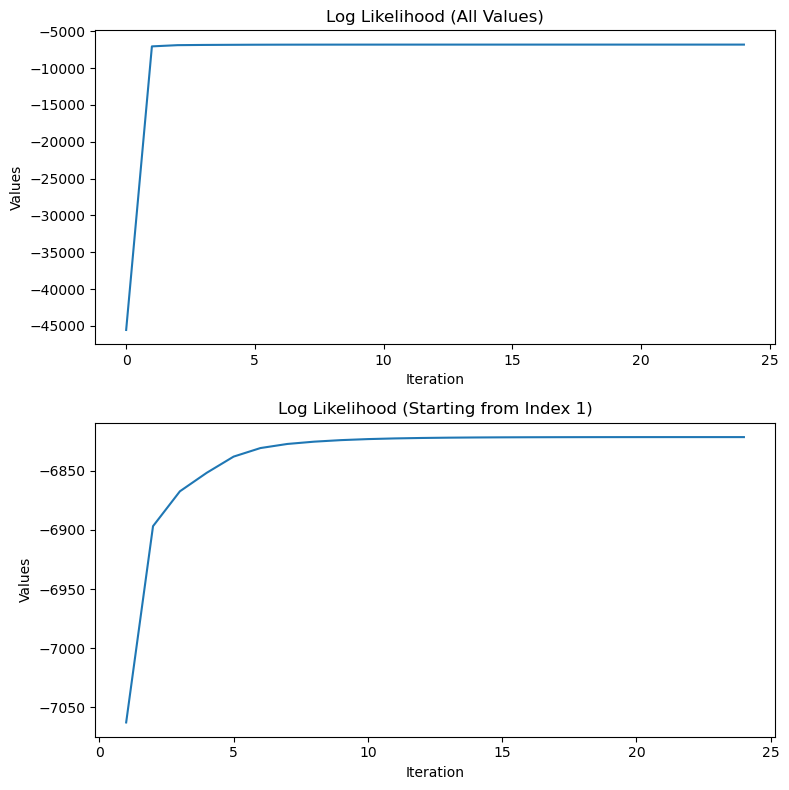

In [43]:
fig, axis = plt.subplots(2, 1, figsize=(8, 8))

ax = axis[0]

ax.plot(np.arange(len(y_vals)), y_vals)
ax.set_title('Log Likelihood (All Values)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Values')


ax = axis[1]
ax.plot(np.arange(1, len(y_vals)), y_vals[1:])
ax.set_title('Log Likelihood (Starting from Index 1)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Values')

plt.tight_layout();